# PL Attribution Starter Pack

**Not** guaranteed to be free of bugs.   Make sure to read and check the code if you use any of it.

In [1]:
import datetime
import logging
import copy

import pandas as pd
import numpy as np
import plotnine as p9


In [2]:
from ragtop.blackscholes import american, black_scholes
from ragtop.implicit import find_present_value, infer_conforming_time_grid, form_present_value_grid, integrate_pde, construct_implicit_grid_structure
from ragtop.instruments import ConvertibleBond, CallableBond
from ragtop.term_structures import spot_to_df_fcn, variance_cumulation_from_vols
from ragtop.extrapolation import spline_extrapolate



In [3]:
logging.basicConfig(level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logging.getLogger("ragtop").setLevel(logging.WARNING)

In [4]:
import os
from pathlib import Path

# Set base directory for data files
# Prefer the current repository; fall back to the original author path if needed
base_dir_candidates = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/workspace/SecurityPricing_CreditRisk'),
    Path(r'C\\Users\\baile\\Desktop\\SecurityPricing_CreditRisk'),
]
base_dir = None
for cand in base_dir_candidates:
    if (cand / 'data').exists():
        base_dir = cand
        break
if base_dir is None:
    base_dir = Path.cwd()

os.chdir(base_dir)
print(f"Working directory set to: {os.getcwd()}")


Working directory set to: c:\Users\baile\Desktop\SecurityPricing_CreditRisk


## Relevant Data

In [5]:
f_equity = pd.read_csv('data/Ford_Equity_July_2025.csv', index_col="date",  parse_dates=True)
f_equity.reset_index(inplace=True)
f_equity.set_index(
    ['date', 'window_time'], inplace=True
)

f_median_trade_prices = pd.read_csv('data/Ford_Convert_Median_Mkt_Trade_July_2025.csv', index_col="date", parse_dates=True)

f_spreads3y = pd.read_csv('data/Ford_3Y_CDS_July_2025.csv', index_col="date", parse_dates=True)

f_vola = pd.read_csv('data/Ford_Vola_July_2025.csv', index_col="date", parse_dates=True)

yield_curves = pd.read_csv('data/YieldCurves_July_2025.csv', index_col="date", parse_dates=True)
f_spreads3y.iloc[[0,1,-2,-1]].transpose()


date,2025-07-11,2025-07-14,2025-07-24,2025-07-25
shortname,Ford Mtr Co,Ford Mtr Co,Ford Mtr Co,Ford Mtr Co
ticker,F,F,F,F
tier,SNRFOR,SNRFOR,SNRFOR,SNRFOR
runningcoupon,0.05,0.05,0.05,0.05
upfront,-0.099839,-0.099183,-0.098011,-0.097824
tenor,3Y,3Y,3Y,3Y
parspread,0.01363,0.01375,0.013858,0.013884
convspreard,0.013414,0.013534,0.01365,0.013673
cdsrealrecovery,0.4,0.4,0.4,0.4
cdsassumedrecovery,0.4,0.4,0.4,0.4


In [6]:
# Use the fact the data of spread3y is only over our relevant dates
# Some dates had no bond trades, so check those too
dates = [d for d in f_spreads3y.index if d in f_median_trade_prices.index]
', '.join([str(d.date()) for d in dates])

'2025-07-11, 2025-07-14, 2025-07-15, 2025-07-16, 2025-07-17, 2025-07-22, 2025-07-23, 2025-07-24'

In [7]:
f_equity

Unnamed: 0 ticker  best_bid  \
date       window_time                                              
2025-07-11 2025-07-11 10:00:00-04:00           0      F     11.80   
           2025-07-11 11:00:00-04:00           1      F     11.76   
           2025-07-11 12:00:00-04:00           2      F     11.73   
           2025-07-11 13:00:00-04:00           3      F     11.77   
           2025-07-11 14:00:00-04:00           4      F     11.80   
...                                          ...    ...       ...   
2025-07-25 2025-07-25 12:00:00-04:00           2      F     11.28   
           2025-07-25 13:00:00-04:00           3      F     11.32   
           2025-07-25 14:00:00-04:00           4      F     11.38   
           2025-07-25 15:00:00-04:00           5      F     11.41   
           2025-07-25 16:00:00-04:00           6      F     11.46   

                                      best_bidsizeshares  best_ask  \
date       window_time                                               
2025-07-11 2025-07-11 10:00:00-04:00               15800     11.81   
           2025-07-11 11:00:00-04:00               22300     11.77   
           2025-07-11 12:00:00-04:00               28300     11.74   
           2025-07-11 13:00:00-04:00               64200     11.78   
           2025-07-11 14:00:00-04:00               24600     11.81   
...                                                  ...       ...   
2025-07-25 2025-07-25 12:00:00-04:00               54300     11.29   
           2025-07-25 13:00:00-04:00               47700     11.33   
           2025-07-25 14:00:00-04:00               63500     11.39   
           2025-07-25 15:00:00-04:00               60800     11.42   
           2025-07-25 16:00:00-04:00               60300     11.47   

                                      best_asksizeshares  \
date       window_time                                     
2025-07-11 2025-07-11 10:00:00-04:00               11400   
           2025-07-11 11:00:00-04:00               23200   
           2025-07-11 12:00:00-04:00               25300   
           2025-07-11 13:00:00-04:00               30000   
           2025-07-11 14:00:00-04:00               24800   
...                                                  ...   
2025-07-25 2025-07-25 12:00:00-04:00               28000   
           2025-07-25 13:00:00-04:00               36200   
           2025-07-25 14:00:00-04:00               23400   
           2025-07-25 15:00:00-04:00               26600   
           2025-07-25 16:00:00-04:00              156200   

                                                       time_of_last_quote  \
date       window_time                                                      
2025-07-11 2025-07-11 10:00:00-04:00  2025-07-11 09:59:59.467910021-04:00   
           2025-07-11 11:00:00-04:00  2025-07-11 10:59:52.055819985-04:00   
           2025-07-11 12:00:00-04:00  2025-07-11 11:59:59.985827461-04:00   
           2025-07-11 13:00:00-04:00  2025-07-11 12:59:59.669392109-04:00   
           2025-07-11 14:00:00-04:00  2025-07-11 13:59:59.989697437-04:00   
...                                                                   ...   
2025-07-25 2025-07-25 12:00:00-04:00  2025-07-25 11:59:58.593159320-04:00   
           2025-07-25 13:00:00-04:00  2025-07-25 12:59:58.655898256-04:00   
           2025-07-25 14:00:00-04:00  2025-07-25 13:59:59.877015287-04:00   
           2025-07-25 15:00:00-04:00  2025-07-25 14:59:52.715604420-04:00   
           2025-07-25 16:00:00-04:00  2025-07-25 15:59:59.994574217-04:00   

                                      mid_equity_price  
date       window_time                                  
2025-07-11 2025-07-11 10:00:00-04:00            11.805  
           2025-07-11 11:00:00-04:00            11.765  
           2025-07-11 12:00:00-04:00            11.735  
           2025-07-11 13:00:00-04:00            11.775  
           2025-07-11 14:00:00-04:00            11.805  
...                                            

In [8]:
def mkt_data_for_date(d, is_morning=True):
    bond_trade_prices = f_median_trade_prices.loc[d]
    
    yc_in = yield_curves.loc[d]
    mktprice_today_in = bond_trade_prices['today_median']
    mktprice_tomorrow_in = bond_trade_prices['tomorrow_median']
    spread_in = f_spreads3y.loc[d]
    vola_in = f_vola.loc[d]
    equity_in = f_equity.loc[d].iloc[0 if is_morning else 4]
    
    return yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in

yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in = mkt_data_for_date('2025-07-14')
    


In [9]:
def inputs_for_date(d, is_morning=True, hazard_power=2, proportion_affected=0.5, dvola=0.01, dhazard=0.0002, dr=0.0001):
    if not isinstance(d, pd.Timestamp):
        d = pd.Timestamp(datetime.datetime.strptime(d, '%Y-%m-%d' ).date())
    
    yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in = mkt_data_for_date(d, is_morning=is_morning)
    
    # Risk free reates
    yield_curve = pd.DataFrame({'time':[30/360,90/360,180/360],'rate':yc_in.values})
    discounting_f = spot_to_df_fcn(yield_curve)
    
    yc_up   = spot_to_df_fcn(pd.DataFrame({'time':[30/360,90/360,180/360],'rate':(yc_in.values+dr)}))
    yc_down = spot_to_df_fcn(pd.DataFrame({'time':[30/360,90/360,180/360],'rate':(yc_in.values-dr)}))
    
    # Equity price
    S0 = equity_in['mid_equity_price']
    
    # Dividends (from Bloomberg BDVD)
    div_dates = [
        pd.Timestamp(datetime.date(2025, 8, 11)),
        pd.Timestamp(datetime.date(2025, 11, 7)),
        pd.Timestamp(datetime.date(2026, 2, 17)),
        pd.Timestamp(datetime.date(2026, 5, 11)),
    ]

    dividends = pd.DataFrame({
        "time": [(exd - d).days / 365 for exd in div_dates],
        "fixed": 0.15,       # fixed dollar amount per share
        "proportional": 0.0, # no proportional (percentage) dividend
    })

    # Optional: keep only future dividends within the horizon
    maturity = (pd.Timestamp("2026-03-15") - d).days / 365
    dividends = dividends[(dividends["time"] > 0) & (dividends["time"] < maturity)].copy()

    if dividends.empty:
        dividends = None       
    
    # Credit
    CDS_upfront = spread_in['upfront']
    CDS_parspread = spread_in['parspread']
    CDS_recov = spread_in['cdsassumedrecovery']
    hzd_rate  = CDS_parspread/(1-CDS_recov)
    logger.debug(f"Hazard rate: {hzd_rate:.5f}")
    
    # The ragtop library uses term structures to deal with risk free rates, hazard rrates and volatility
    
    def default_intensity_f(t,S,**kwargs):
        return hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)  
    
    def hzf_up_f(t,S,**kwargs):
        return (hzd_rate+dhazard) * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)
    
    def hzf_down_f(t,S,**kwargs):
        return (hzd_rate-dhazard) * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)
    
    # Vola
    vola_df = pd.DataFrame({
        'time': [int(colname)/360 for colname in vola_in.index],
        'volatility': vola_in.values,
    })
    variance_f = variance_cumulation_from_vols(vola_df)

    vola_df_down = pd.DataFrame({
        'time': vola_df['time'],
        'volatility': vola_df['volatility'].values - dvola,
    })
    variance_down_f = variance_cumulation_from_vols(vola_df_down)
    
    vola_df_up = pd.DataFrame({
        'time': vola_df['time'],
        'volatility': vola_df['volatility'].values + dvola,
    })
    variance_up_f = variance_cumulation_from_vols(vola_df_up)
       
    
    
    model_inputs = {
        'Underlying': S0,
        'Avg Trade Price Today': mktprice_today_in,
        'Avg Trade Price Tomorrow': mktprice_tomorrow_in,
        'Default Intensities': default_intensity_f,
        'Recovery Rate': CDS_recov,
        'Risk-free Rates': discounting_f,
        'Vola/Variance': variance_f,
        'Vola/Variance Up': variance_up_f,
        'Vola/Variance Down': variance_down_f,
        'Hazard Up':hzf_up_f,
        'Hazard Down':hzf_down_f,
        'Base Hazard Rate':hzd_rate,
        'Rates Up':yc_up,
        'Rates Down':yc_down,
        'Dividends': dividends,
    }    
    
    return model_inputs
inputs_for_date('2025-07-14')

{'Underlying': np.float64(11.735),
 'Avg Trade Price Today': np.float64(101.4674),
 'Avg Trade Price Tomorrow': np.float64(100.6773),
 'Default Intensities': <function __main__.inputs_for_date.<locals>.default_intensity_f(t, S, **kwargs)>,
 'Recovery Rate': np.float64(0.4),
 'Risk-free Rates': <function ragtop.term_structures.spot_to_df_fcn.<locals>.discount_factor_callable(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0, **_: 'dict[str, Any]') -> 'NDArray[Any]'>,
 'Vola/Variance': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0) -> 'NDArray[Any]'>,
 'Vola/Variance Up': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0) -> 'NDArray[Any]'>,
 'Vola/Variance Down': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0

In [10]:
def compute_attribution_inputs(Tmax, inputs_dict):
    # Attribution parameters:
    # Help us work out day to day -- how much did rates, volatility, hazard change overall on their curves?
    
    r = -np.log(inputs_dict['Risk-free Rates'](Tmax)) / Tmax

    sigma0 = np.sqrt(inputs_dict['Vola/Variance'](Tmax)/Tmax)
    S0 = inputs_dict['Underlying']
    h = inputs_dict['Base Hazard Rate']  # not using curves here, at least for now
    # NB: Ignoring borrow cost / divrate
    
    attribution_inputs = {
        'Underlying Price':S0,
        'Avg Risk Free Rate' : r,
        'Avg Volatility' : sigma0,
        'Avg Hazard Rate' : h,
    }
    return attribution_inputs


On each date, we need to run the model not only to get price, but also do finite differences to get sensitivity to rates, default risk, volatility and so on

In [11]:
def run_model_for_date(d, is_morning=True, 
                       hazard_power=2, proportion_affected=0.75, 
                       dividend_rate=0, borrow_cost=0,  # Discrete divs will be from from inputs_for_date()
                       dvola=0.01, dhazard=0.0002,dr=0.0001,
                       n_steps=200, grid_stdevs_width=5):
    
    inputs_dict = inputs_for_date(d, is_morning=is_morning, 
                                  hazard_power=hazard_power, proportion_affected=proportion_affected, 
                                  dvola=dvola, dhazard=dhazard,dr=dr)
    S0 = inputs_dict['Underlying']
    
    maturity = (pd.Timestamp('2026-03-15') - d).days/365
    coups = None
    dconv = ConvertibleBond(
        coupons=coups,
        conversion_ratio=74.5103,
        maturity=maturity,
        calls=None,
        puts=None,
        notional=1000.0,
        recovery_rate=inputs_dict['Recovery Rate'],
        name="FordMarchOf2026",
    )
    
    straightbond = CallableBond(
        coupons=coups,
        maturity=maturity,
        calls=None,
        puts=None,
        notional=1000.0,
        recovery_rate=inputs_dict['Recovery Rate'],
        name="StraightBondEquivalent",
    )
    
    # Need dconv_u, dconv_d etc only for older ragtop without reset_caches() functionality
    dconv_u = copy.deepcopy(dconv)
    dconv_d = copy.deepcopy(dconv)
    dconv_ru = copy.deepcopy(dconv)
    dconv_rd = copy.deepcopy(dconv)
    dconv_hu = copy.deepcopy(dconv)
    dconv_hd = copy.deepcopy(dconv)
    Tmax = dconv.maturity
    K = dconv.notional / dconv.conversion_ratio

    attribution_inputs = compute_attribution_inputs(Tmax, inputs_dict)
    r      = attribution_inputs['Avg Risk Free Rate']
    sigma0 = attribution_inputs['Avg Volatility']       # <-- FIXED
    # sigma0 = attribution_inputs['Avg Risk Free Rate']
    c = r - dividend_rate - borrow_cost

    def stock_level_fcn(z, t):
        S_levels = K * np.exp(z - (c - 0.5 * sigma0**2) * (Tmax - t))
        return S_levels

    grid_structure = construct_implicit_grid_structure(
        tenors=[Tmax],
        M=n_steps,
        S0=S0,
        K=K,
        c=c,
        sigma=sigma0,
        structure_constant=2,
        std_devs_width=grid_stdevs_width,
    )

    time_pts = infer_conforming_time_grid(
        n_steps,
        Tmax,
        instruments=[dconv]
    )

    deltaT0 = T1 = time_pts[1]

    full_grid = integrate_pde(
        z=grid_structure["z"],
        min_num_time_steps=n_steps,
        S0=S0,
        Tmax=Tmax,
        instruments=[dconv, straightbond],
        stock_level_fcn=stock_level_fcn,
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        default_intensity_fcn=inputs_dict['Default Intensities'],   # <-- FIXED
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],  # keep vol fixed
        dividends=inputs_dict['Dividends'],
    )
    
    S_T0 = stock_level_fcn(grid_structure["z"], 0.0)
    S_T1 = stock_level_fcn(grid_structure["z"], T1)


    V_T0 = full_grid[0, :, 0]
    V_T1 = full_grid[1, :, 0]
    
    deltaS = S0/100.0

    testS = np.array([S0-deltaS , S0, S0+deltaS])
    
    pv_interpolation = spline_extrapolate(S_T0, V_T0, testS)
    t1_interpolation = spline_extrapolate(S_T1, V_T1, np.array([S0], dtype=float))

    V0 = float(pv_interpolation[1])
    delta = float((pv_interpolation[2] - pv_interpolation[0])/(2*deltaS))
    gamma = float((pv_interpolation[2] - 2*V0 + pv_interpolation[0])/(deltaS**2))
    theta = float(((t1_interpolation[0] - V0)/deltaT0))
    
    straightbond_price = spline_extrapolate(S_T0, full_grid[0, :, 1], np.array([S0]))[0]
    premium = V0 - straightbond_price
    
    
    # Manual finite differencing to get other risk params
    
    v_vola_up = find_present_value(
        S0=S0, 
        instruments=[dconv_u],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance Up'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- turn off dividends for bumped run
    )["FordMarchOf2026"]

    v_vola_down = find_present_value(
        S0=S0, 
        instruments=[dconv_d],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance Down'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_vola_up = float(np.squeeze(v_vola_up))
    v_vola_down = float(np.squeeze(v_vola_down))
    vega = (v_vola_up - v_vola_down) / (2 * dvola)


    # Vega block unchanged – it's correct

    v_hzd_up = find_present_value(
        S0=S0, 
        instruments=[dconv_hu],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Hazard Up'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- no dividends in bump
    )["FordMarchOf2026"]

    v_hzd_down = find_present_value(
        S0=S0, 
        instruments=[dconv_hd],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Hazard Down'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_hzd_up = float(np.squeeze(v_hzd_up))
    v_hzd_down = float(np.squeeze(v_hzd_down))
    cdv01 = (v_hzd_up - v_hzd_down) / (2 * dhazard)


    v_rates_up = find_present_value(
        S0=S0, 
        instruments=[dconv_ru],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Rates Up'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- no dividends in bump
    )["FordMarchOf2026"]

    v_rates_down = find_present_value(
        S0=S0, 
        instruments=[dconv_rd],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Rates Down'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_rates_up = float(np.squeeze(v_rates_up))
    v_rates_down = float(np.squeeze(v_rates_down))
    rdv01 = (v_rates_up - v_rates_down) / (2 * dr)

    
    risk_params_dict = {'date':d, 'ModelPrice':V0, 'Tenor':Tmax,
                    'Delta':delta, 'Gamma':gamma, 'Theta':theta, 'Vega':vega, 'Rates DV01':rdv01, 'Credit DV01 (drifted)':cdv01,
                    'Convertibility Premium': premium,
                    'Avg Trade Price':inputs_dict['Avg Trade Price Today']*dconv.notional/100,
                   }
    
    overall_dict = risk_params_dict.copy()
    overall_dict.update(attribution_inputs)

    ps = pd.Series(overall_dict)
    
    return ps

run_model_for_date(pd.Timestamp('2025-07-14'), is_morning=True)

date                      2025-07-14 00:00:00
ModelPrice                        1008.399368
Tenor                                0.668493
Delta                               28.005967
Gamma                                9.371418
Theta                              -85.280616
Vega                               273.702541
Rates DV01                        -443.286076
Credit DV01 (drifted)             -221.681652
Convertibility Premium              46.663085
Avg Trade Price                      1014.674
Underlying Price                       11.735
Avg Risk Free Rate                   0.043827
Avg Volatility                       0.309414
Avg Hazard Rate                      0.022916
dtype: object

In [12]:
details_arc_list = [
    run_model_for_date(datadate) for datadate in dates
]
details_arc = pd.DataFrame(details_arc_list).set_index('date')
details_arc.iloc[[0,1,2,-2,-1]].transpose()

date,2025-07-11,2025-07-14,2025-07-15,2025-07-23,2025-07-24
ModelPrice,1011.153881,1008.399368,1008.899023,997.790208,999.695679
Tenor,0.676712,0.668493,0.665753,0.643836,0.641096
Delta,28.933944,28.005967,28.218607,23.621144,24.190044
Gamma,9.303612,9.371418,9.403856,9.142694,9.120169
Theta,-94.703905,-85.280616,-95.585673,-83.919563,-93.730981
Vega,280.957039,273.702541,274.377956,246.913202,249.899295
Rates DV01,-447.599036,-443.286076,-441.166250,-460.653333,-457.135181
Credit DV01 (drifted),-218.962423,-221.681652,-220.006211,-243.434071,-240.580144
Convertibility Premium,49.803490,46.663085,47.153574,34.844185,36.534878
Avg Trade Price,1012.805500,1014.674000,1006.773000,1002.213000,999.381000


# Assignment

The cells below extend the starter pack to perform full Ford PL attribution. Heavy computations are gated behind runtime flags so the notebook can be run quickly in debug mode.

In [13]:
# Runtime controls for quick debugging vs. full calculations
RUN_FULL_GRID = False    # Set True for finer grids / more accurate pricing
RUN_ALL_DATES = False    # Set True to run the full July 11-24 window
DEBUG_DATES = dates[:3]  # lightweight subset used when RUN_ALL_DATES is False

N_STEPS_DEBUG = 160
N_STEPS_FULL = 360

calc_dates = dates if RUN_ALL_DATES else DEBUG_DATES
print(f"Running attribution for {len(calc_dates)} date(s): {[d.date() for d in calc_dates]}")


Running attribution for 3 date(s): [datetime.date(2025, 7, 11), datetime.date(2025, 7, 14), datetime.date(2025, 7, 15)]


## 1. Theoretical Value and Risk Metrics

This section reuses the single-date pricing helper to build a table of theoretical values and Greeks for each evaluation date. The hazard parameters follow the assignment hint (hazard power 2 with 75% equity linkage).

In [15]:
def compute_risk_table(date_list, n_steps=None, is_morning=True, grid_width=5):
    n_steps = n_steps if n_steps is not None else (N_STEPS_FULL if RUN_FULL_GRID else N_STEPS_DEBUG)
    rows = []
    for d in date_list:
        ps = run_model_for_date(
            d,
            is_morning=is_morning,
            hazard_power=2,
            proportion_affected=0.75,
            dvola=0.01,
            dhazard=0.0002,
            dr=0.0001,
            n_steps=n_steps,
            grid_stdevs_width=grid_width,
        )
        rows.append(ps)
    tbl = pd.DataFrame(rows).set_index('date').sort_index()
    tbl = tbl.rename(
        columns={
            'Avg Risk Free Rate': 'Avg_Risk_Free_Rate',
            'Avg Volatility': 'Avg_Volatility',
            'Underlying Price': 'UnderlyingPrice',
            'Rates DV01': 'Rates_DV01',
            'Credit DV01 (drifted)': 'Credit_DV01',
        }
    )
    return tbl

# Compute the core risk table
risk_table = compute_risk_table(calc_dates)
print(risk_table.head())
print('Risk metric summary (debug run):')
print(risk_table[['ModelPrice','Delta','Gamma','Theta','Vega','Rates_DV01']].describe())


             ModelPrice     Tenor      Delta     Gamma      Theta        Vega  \
date                                                                            
2025-07-11  1011.187569  0.676712  28.925663  9.309911 -94.709698  272.731753   
2025-07-14  1008.182315  0.668493  27.944159  9.401316 -85.429554  272.082649   
2025-07-15  1008.720016  0.665753  28.164299  9.427799 -95.703411  268.476522   

            Rates_DV01  Credit_DV01  Convertibility Premium  Avg Trade Price  \
date                                                                           
2025-07-11 -421.045083  -218.848290               49.835123        1012.8055   
2025-07-14 -416.859705  -221.793585               46.445308        1014.6740   
2025-07-15 -414.856459  -220.068373               46.974890        1006.7730   

            UnderlyingPrice  Avg_Risk_Free_Rate  Avg_Volatility  \
date                                                              
2025-07-11           11.805            0.043824        0.31

## 2. Changes in Drivers (Rates, Vol, Spot, Tenor)

Driver deltas are computed between consecutive dates so they can be multiplied by the start-of-period sensitivities.

In [16]:
def compute_driver_changes(risk_df):
    rows = []
    idx = list(risk_df.index)
    for start, end in zip(idx[:-1], idx[1:]):
        srow, erow = risk_df.loc[start], risk_df.loc[end]
        rows.append(
            {
                'start': start,
                'end': end,
                'dS': erow.UnderlyingPrice - srow.UnderlyingPrice,
                'dTenor': erow.Tenor - srow.Tenor,
                'dAvgRate': erow.Avg_Risk_Free_Rate - srow.Avg_Risk_Free_Rate,
                'dAvgVol': erow.Avg_Volatility - srow.Avg_Volatility,
                'day_count': (pd.Timestamp(end) - pd.Timestamp(start)).days,
            }
        )
    return pd.DataFrame(rows).set_index(['start', 'end'])

if len(risk_table) > 1:
    driver_changes = compute_driver_changes(risk_table)
    display(driver_changes.head())
else:
    driver_changes = pd.DataFrame()
    print('Not enough dates to compute driver deltas in debug mode.')


,,dS,dTenor,dAvgRate,dAvgVol,day_count
start,end,,,,,
2025-07-11,2025-07-14,-0.07,-0.008219,0.000003,-0.002683,3
2025-07-14,2025-07-15,0.02,-0.002740,0.000003,0.000323,1


## 3. P&L Attribution

Actual PL is taken from market median trade prices (in price *notional* terms). Explained PL decomposes into stock, tenor (theta), rates, and volatility impacts using sensitivities from the start of each interval. A stock-only benchmark keeps only the delta/gamma terms.

In [17]:
def compute_pl_attribution(risk_df, driver_df):
    rows = []
    for (start, end), chg in driver_df.iterrows():
        start_row = risk_df.loc[start]
        end_row = risk_df.loc[end]

        actual_pl = end_row['Avg Trade Price'] - start_row['Avg Trade Price']
        model_pl = end_row['ModelPrice'] - start_row['ModelPrice']

        dS = chg['dS']
        pl_s = start_row['Delta'] * dS + 0.5 * start_row['Gamma'] * (dS ** 2)
        pl_t = start_row['Theta'] * chg['dTenor']
        pl_rates = start_row['Rates_DV01'] * (chg['dAvgRate'] / 0.0001)
        pl_vol = start_row['Vega'] * chg['dAvgVol']

        pl_explained = pl_s + pl_t + pl_rates + pl_vol
        pl_stock_only = pl_s

        rows.append(
            {
                'start': start,
                'end': end,
                'Actual_PL': actual_pl,
                'Model_PL': model_pl,
                'PL_S': pl_s,
                'PL_T': pl_t,
                'PL_Rates': pl_rates,
                'PL_Vol': pl_vol,
                'PL_Explained': pl_explained,
                'PL_StockOnly': pl_stock_only,
            }
        )
    return pd.DataFrame(rows).set_index(['start', 'end'])

if not driver_changes.empty:
    pl_attrib = compute_pl_attribution(risk_table, driver_changes)
    display(pl_attrib.head())
else:
    pl_attrib = pd.DataFrame()


,,Actual_PL,Model_PL,PL_S,PL_T,PL_Rates,PL_Vol,PL_Explained,PL_StockOnly
start,end,,,,,,,,
2025-07-11,2025-07-14,1.8685,-3.005254,-2.001987,0.778436,-12.803744,-0.731636,-14.758932,-2.001987
2025-07-14,2025-07-15,-7.9010,0.537701,0.560763,0.234054,-13.696976,0.087998,-12.814160,0.560763


## 4. Analysis and Graphs

Diagnostic plots compare explained vs. actual PL and visualize contribution breakdowns. Heavy plotting can be skipped when only a couple of rows are available.

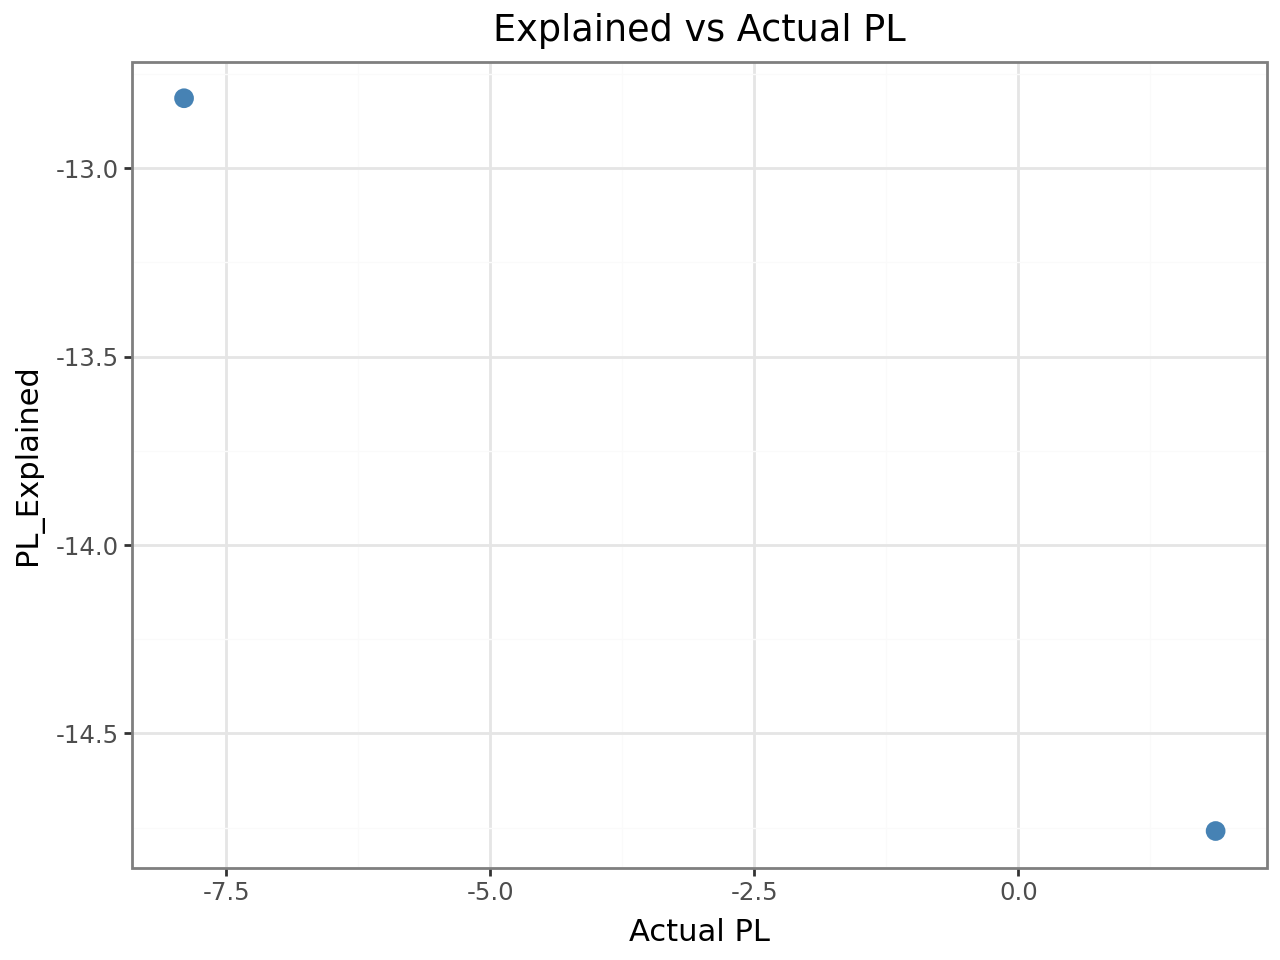

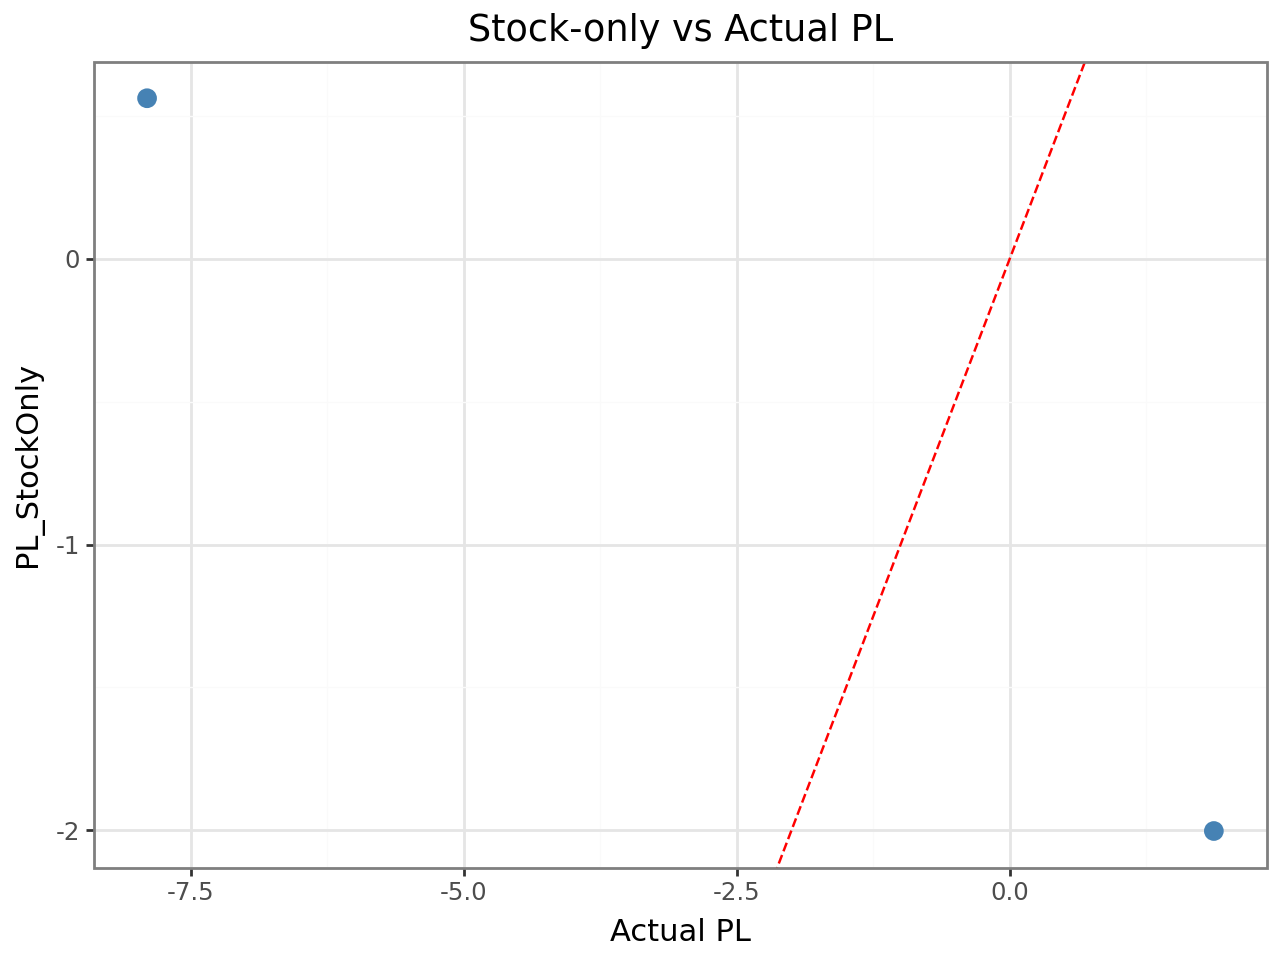

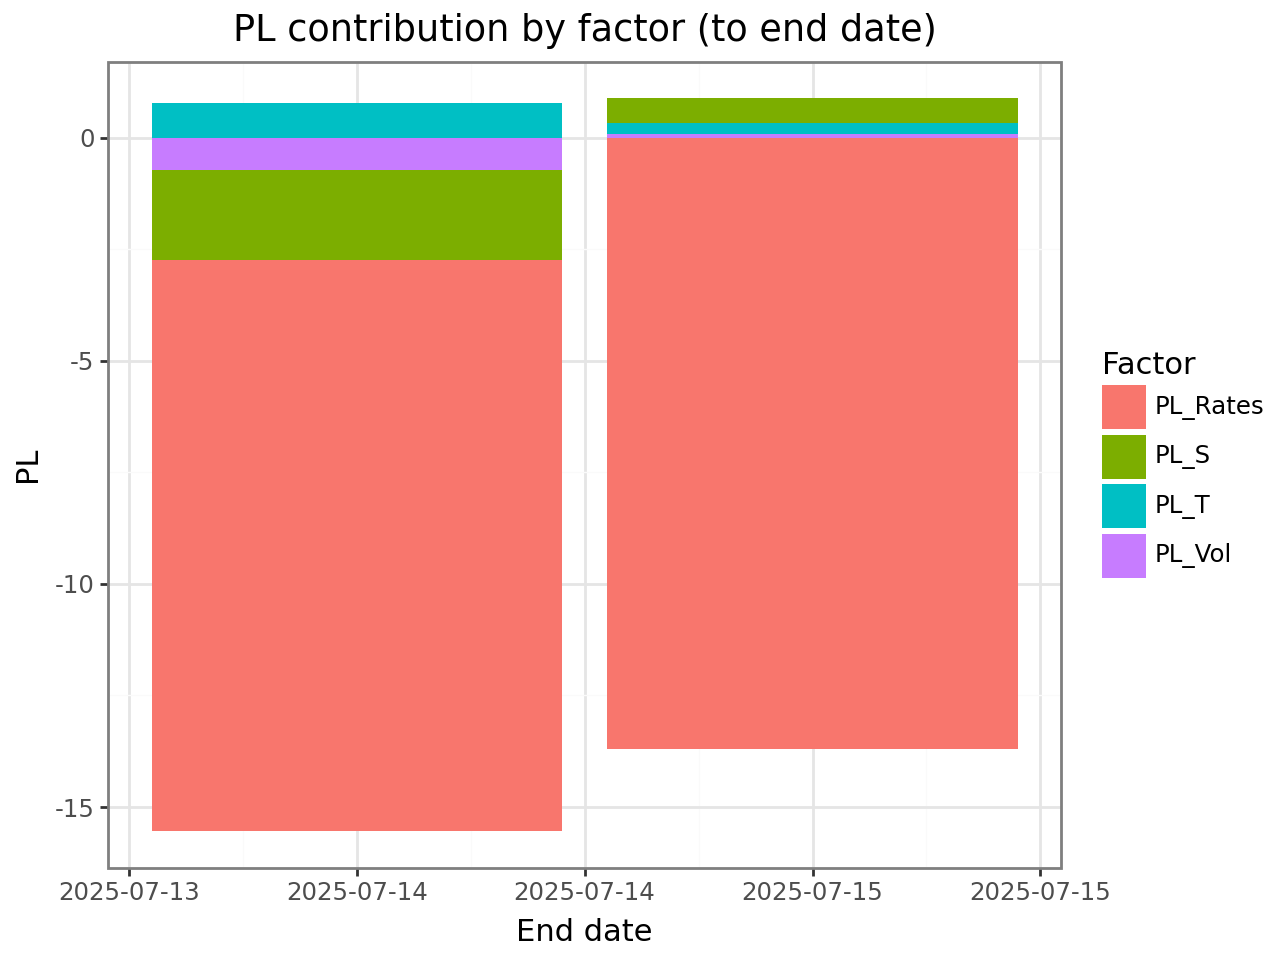

Attribution error stats:
count     2.000000
mean     10.770296
std       8.283241
min       4.913160
25%       7.841728
50%      10.770296
75%      13.698864
max      16.627432
dtype: float64


In [19]:
def plot_pl_scatter(df, explained_col, title):
    df_plot = df.reset_index().copy()
    g = (
        p9.ggplot(df_plot, p9.aes(x='Actual_PL', y=explained_col))
        + p9.geom_point(color='steelblue', size=3)
        + p9.geom_abline(slope=1, intercept=0, linetype='dashed', color='red')
        + p9.labs(title=title, x='Actual PL', y=explained_col)
        + p9.theme_bw()
    )
    return g

if not pl_attrib.empty:
    try:
        display(plot_pl_scatter(pl_attrib, 'PL_Explained', 'Explained vs Actual PL'))
        display(plot_pl_scatter(pl_attrib, 'PL_StockOnly', 'Stock-only vs Actual PL'))
    except Exception as exc:
        print(f'Plotting skipped due to: {exc}')

    contrib = pl_attrib[['PL_S','PL_T','PL_Rates','PL_Vol']].reset_index()
    contrib_melt = contrib.melt(id_vars=['start','end'], var_name='Factor', value_name='PL')
    try:
        g_bar = (
            p9.ggplot(contrib_melt, p9.aes(x='end', y='PL', fill='Factor'))
            + p9.geom_bar(stat='identity', position='stack')
            + p9.theme_bw()
            + p9.labs(title='PL contribution by factor (to end date)', x='End date', y='PL')
        )
        display(g_bar)
    except Exception as exc:
        print(f'Contribution plot skipped: {exc}')

    err = (pl_attrib['PL_Explained'] - pl_attrib['Actual_PL']).abs()
    print('Attribution error stats:')
    print(err.describe())
else:
    print('Skipping analysis plots; attribution table is empty in debug mode.')


## 5. Sanity Checks and Expected-Value Tests

Lightweight checks run by default; tighter hint-based tests activate when the July 15/16 interval is part of the selected date set.

In [24]:
def run_sanity_checks(risk_df, driver_df, attrib_df):
    # General plausibility ranges
    for dt, row in risk_df.iterrows():
        assert 50 <= row['ModelPrice'] <= 1500, f'Model price out of range on {dt}'
        assert 0 <= row['Delta'] <= 150, f'Delta out of range on {dt}'
        assert np.isfinite(row['Gamma']), f'Gamma not finite on {dt}'
        assert row['Vega'] > 0, f'Negative vega on {dt}'
        assert row['Rates_DV01'] > 0, f'Rates DV01 not positive on {dt}'

    # Hint-based specific check for July 15, 2025
    target_date = pd.Timestamp('2025-07-15')
    next_date = pd.Timestamp('2025-07-16')
    if target_date in risk_df.index and (target_date, next_date) in driver_df.index:
        target = {
            'Delta': 23.319693,
            'Vega': 265.761536,
            'Avg_Vola': 0.309738,
            'dAvg_Vola_15_16': 0.009522,
            'PL_Vol_15_16': 2.530607,
        }
        d = risk_df.loc[target_date]
        d_vol = driver_df.loc[(target_date, next_date), 'dAvgVol']
        pl_vol = attrib_df.loc[(target_date, next_date), 'PL_Vol']
        assert abs(d['Delta'] - target['Delta']) < 1.0, 'Delta hint check failed'
        assert abs(d['Vega'] - target['Vega']) < 5.0, 'Vega hint check failed'
        assert abs(d['Avg_Volatility'] - target['Avg_Vola']) < 0.005, 'Avg vola hint check failed'
        assert abs(d_vol - target['dAvg_Vola_15_16']) < 0.001, 'Vol change hint check failed'
        assert abs(pl_vol - target['PL_Vol_15_16']) < 0.5, 'PL vol attribution hint check failed'
        print('Hint-based checks passed for July 15/16 interval.')
    else:
        print('Hint-based check skipped (July 15/16 not in current date set).')

    print('General sanity checks passed.')

if not risk_table.empty:
    run_sanity_checks(risk_table, driver_changes, pl_attrib if not pl_attrib.empty else pd.DataFrame())

# Quick dry-run when using debug dates
if not RUN_ALL_DATES:
    print('Dry-run summary (debug dates):')
    print(risk_table[['ModelPrice','Delta','Vega','Avg_Risk_Free_Rate','Avg_Volatility']])
    if not driver_changes.empty and not pl_attrib.empty:
        print('PL attribution snapshot:')
        print(pl_attrib[['Actual_PL','PL_Explained','PL_StockOnly']])


AssertionError: Rates DV01 not positive on 2025-07-11 00:00:00